# 导入包

In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
tf.enable_eager_execution()
import matplotlib.pyplot as plt
import os



1.13.1


# 构造生成器和判别器

## 构造生成器类


![avatar](http://ppfijofch.bkt.clouddn.com/net1.PNG)

In [2]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    
    #全连接层
    self.fc1 = tf.keras.layers.Dense(units=4*4*512, activation=None)
    
    # BN + ReLU
    self.bn1 = tf.keras.layers.BatchNormalization(scale=False)
    self.activation1 = tf.keras.layers.Activation(activation='relu')
    
    # 转置卷积层1  转置卷积为shape：(batch_size, 8, 8, 256)
    self.transp_conv1 = tf.keras.layers.Conv2DTranspose(256, 5, strides=2, padding="SAME", activation=None)
    
    # BN + ReLU
    self.bn2 = tf.keras.layers.BatchNormalization(scale=False)
    self.activation2= tf.keras.layers.Activation(activation='relu')
    
    # 转置卷积层2  转置卷积为shape：(batch_size, 16, 16, 128)
    self.transp_conv2 = tf.keras.layers.Conv2DTranspose(128, 5, strides=2, padding="SAME", activation=None)
    
    # BN + ReLU
    self.bn3 = tf.keras.layers.BatchNormalization(scale=False)
    self.activation3= tf.keras.layers.Activation(activation='relu')
    
   # 转置卷积层3  转置卷积为shape：(batch_size, 32, 32, 64)
    self.transp_conv3 = tf.keras.layers.Conv2DTranspose(64, 5, strides=2, padding="SAME", activation=None)
    
    # BN + ReLU
    self.bn4 = tf.keras.layers.BatchNormalization(scale=False)
    self.activation4= tf.keras.layers.Activation(activation='relu')

    
    # 转置卷积层4  转置卷积为shape：(batch_size, 64, 64, 3)
    self.transp_conv4 = tf.keras.layers.Conv2DTranspose(3, 5, strides=2, padding="SAME", activation=None)
    self.out = tf.keras.layers.Activation(activation='tanh')
  #call函数让类可以作为函数被调用  
  def call(self,z, is_training):

    fc1 = self.fc1(z)
    fc1_reshaped = tf.reshape(fc1, (-1,4,4,512))

    bn1 = self.bn1(fc1_reshaped, training=is_training)
    activation1 = self.activation1(bn1)

    trans_conv1 = self.transp_conv1(activation1) 
    bn2 = self.bn2(trans_conv1, training=is_training)
    activation2 = self.activation2(bn2)

    transp_conv2 = self.transp_conv2(activation2) 
    bn3 = self.bn3(transp_conv2, training=is_training)
    activation3 = self.activation3(bn3)
    
    transp_conv3 = self.transp_conv3(activation3) 
    bn4 = self.bn4(transp_conv3, training=is_training)
    activation4 = self.activation4(bn4)
    
    transp_conv4 = self.transp_conv4(activation4) 
    output = self.out(transp_conv4)
    
    return output

## 构造判别器类

![avatar](http://ppfijofch.bkt.clouddn.com/net2.PNG)

In [3]:

class Discriminator(tf.keras.Model):
  def __init__(self, alpha):
    super(Discriminator, self).__init__()
    # 卷积层1  卷积为shape：(batch_size, 32, 32, 64)
    self.conv1 = tf.keras.layers.Conv2D(64, 5, strides=2, padding='SAME', activation=None)
    self.activation1 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    # 卷积层2  卷积为shape：(batch_size, 16, 16, 128)
    self.conv2 = tf.keras.layers.Conv2D(128, 5, strides=2, padding='SAME', activation=None)
    self.bn1 = tf.keras.layers.BatchNormalization(scale=False)
    self.activation2 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    # 卷积层3  卷积为shape：(batch_size, 8, 8, 256)
    self.conv3 = tf.keras.layers.Conv2D(256, 5, strides=2, padding='SAME', activation=None)
    self.bn2 = tf.keras.layers.BatchNormalization(scale=False)
    self.activation3 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    # 卷积层4  卷积为shape：(batch_size, 4, 4, 512)
    self.conv4 = tf.keras.layers.Conv2D(512, 5, strides=2, padding='SAME', activation=None)
    self.bn3 = tf.keras.layers.BatchNormalization(scale=False)
    self.activation4 = tf.keras.layers.LeakyReLU(alpha=alpha)
    
    # 把输入拉成一维向量  卷积为shape：(batch_size*4*4*512)
    self.flatten = tf.keras.layers.Flatten()
    self.fc1 = tf.keras.layers.Dense(units=1, activation=None)
    self.out = tf.keras.layers.Activation(activation='sigmoid')
  
  def call(self, inputs, is_training):

    conv1 = self.conv1(inputs)
    activation1 = self.activation1(conv1)
    
    conv2 = self.conv2(activation1)
    bn1 = self.bn1(conv2, training=is_training)
    activation2 = self.activation2(bn1)
    
    conv3 = self.conv3(activation2)
    bn2 = self.bn2(conv3, training=is_training)
    activation3 = self.activation3(bn2)
    
    conv4 = self.conv4(activation3)
    bn3 = self.bn3(conv4, training=is_training)
    activation4 = self.activation4(bn3)
    
    flat = self.flatten(activation4)
    logits = self.fc1(flat)
    out = self.out(logits)
    return out, logits

# 设置参数

In [4]:

z_dim = 100 #输入噪声维度
learning_rate = 0.0002 

alpha = 0.2 #leakyRelu的斜率
beta1 = 0.5 #Adm优化器的衰减率
smooth=0.1

batch_size = 128

counter = 0 #训练次数
epoch=10 #迭代次数
image_size=108 #裁剪图像的大小
image_shape=[64,64,3]
sample_num = 64 #测试图像的数量

In [5]:
generator_net = Generator()
discriminator_net = Discriminator(alpha=alpha)

# 定义代价函数

In [6]:
def discriminator_loss(d_logits_real, d_logits_fake, smooth=0.1):
    
    #判别器两个代价函数
    #输入真图片，判断逼近1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))

    #输入假图片，判断逼近0
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss

In [7]:
def generator_loss(d_logits_fake, d_model_fake):
  
    #生成器一个代价函数
    #输入假图片，迷惑判别器判断逼近1
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    return g_loss

# 定义优化器

In [8]:
global_counter = tf.train.get_or_create_global_step()
generator_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

# 处理数据和数据显示

In [9]:
from glob import glob
#数据集
##获取所有图片路径
datas=glob(os.path.join('../input/img_align_celeba/img_align_celeba/','*.jpg'))

In [10]:
def display_images(dataset, figsize=(4,4), denomalize=True):
    fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=figsize,)
    for ii, ax in enumerate(axes.flatten()):
        img = dataset[ii,:,:,:]
        if denomalize:
            img = ((img + 1)*255 / 2).astype(np.uint8) # Scale back to 0-255
        
        ax.imshow(img)
      
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [11]:
import scipy.misc
import numpy as np
from PIL import Image
from glob import glob

# Helpers for image handling
def get_image(image_path, image_size, is_crop=True):
    return transform(imread(image_path), image_size, is_crop)

def save_images(images, image_path):
    for imgindex in range(images.shape[0]):
        scipy.misc.imsave(image_path+str(imgindex)+'.jpg',images[imgindex])

def imread(path):
    return scipy.misc.imread(path).astype(np.float)

def transform(image, npx=64, is_crop=True):
    # npx : # of pixels width/height of image
    if is_crop:
        cropped_image = center_crop(image, npx)
    else:
        cropped_image = image
    return np.array(cropped_image)/127.5 - 1.

def center_crop(x, crop_h, crop_w=None, resize_w=64): 
    if crop_w is None:
        crop_w = crop_h
    h, w = x.shape[:2]
    j = int(round((h - crop_h)/2.))
    i = int(round((w - crop_w)/2.))
    return scipy.misc.imresize(x[j:j+crop_h, i:i+crop_w], [resize_w, resize_w])

#def imsave(images, size, path):
 #   return scipy.misc.imsave(path, merge(images, size))

def inverse_transform(images):
    return (images+1.)/2.

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))

    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx / size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image

    return img


def convert_to_lower_resolution():
    images=glob(os.path.join('cars_train\cars_train/','*.jpg'))
    i=0
    size=108,108
    for image in images:

        im=Image.open(image)
        im_resized=im.resize(size,Image.ANTIALIAS)
        im_resized.save("cars_train/"+str(i)+'.jpg')

# 运行模型

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Instructions for updating:
Colocations handled automatically by placer.


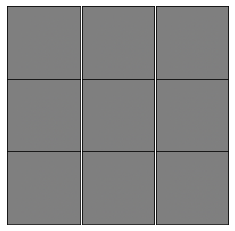

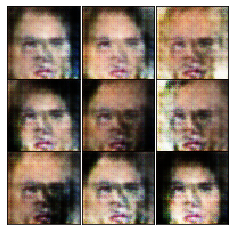

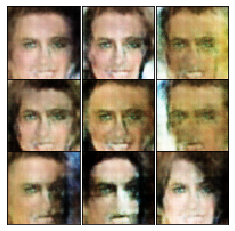

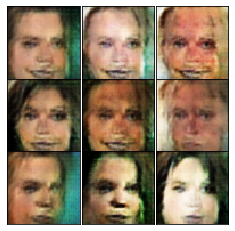

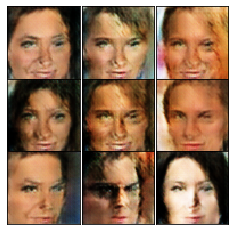

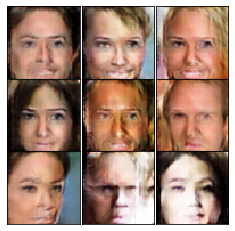

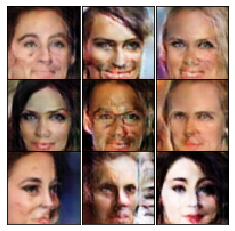

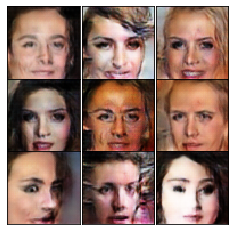

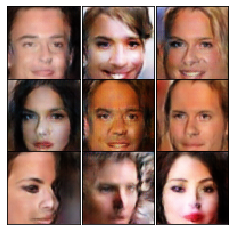

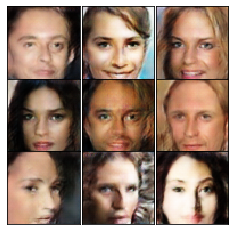

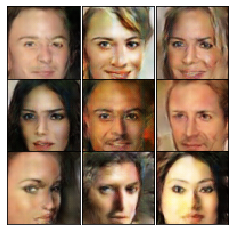

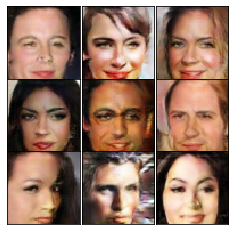

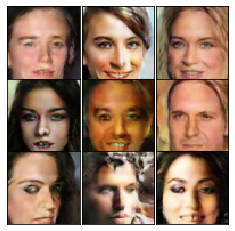

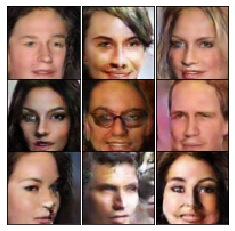

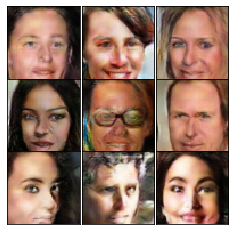

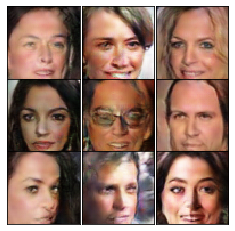

In [12]:
# 生成测试噪声输入
fake_input_test = tf.random_uniform(shape=(sample_num, z_dim),
                                 minval=-1.0, maxval=1.0, dtype=tf.float32)

num_batch = (int)(len(datas)/batch_size)
temp = 1
for i in range(epoch):
    #随机打乱数据
    np.random.shuffle(datas)
    for ii in range(num_batch):
        #生成以batch为单位的随机噪声
        fake_input = tf.random_uniform(shape=(batch_size, z_dim),
                                     minval=-1.0, maxval=1.0, dtype=tf.float32)
        
        #因为数据过大，采用以batch为单位处理数据集的做法
        batch_files=datas[ii*batch_size:(ii+1)*batch_size]
        batch=[get_image(batch_file,image_size,is_crop=True) for batch_file in batch_files]
        batch_images=np.reshape(np.array(batch).astype(np.float32),[batch_size]+image_shape)

        with tf.GradientTape(persistent=True) as tape:
    
            # 运行生成器
            g_model = generator_net(fake_input, is_training=True)

            # 输入真图片运行判别器
            d_model_real, d_logits_real = discriminator_net(batch_images, is_training=True)

            # 输入假图片运行判别器
            d_model_fake, d_logits_fake = discriminator_net(g_model, is_training=True)

            # 计算生成器的损失
            gen_loss = generator_loss(d_logits_fake, d_model_fake)

            # 计算判别器的损失
            dis_loss = discriminator_loss(d_logits_real, d_logits_fake, smooth)

            

            if counter % 1000 == 0:
                generated_samples = generator_net(fake_input_test, is_training=False)
                display_images(generated_samples.numpy())
            
            #为变量计算梯度
            discriminator_grads = tape.gradient(dis_loss, discriminator_net.variables)
            generator_grads = tape.gradient(gen_loss, generator_net.variables)
            
            #进行梯度更新
            discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator_net.variables), global_step=global_counter)
            generator_optimizer.apply_gradients(zip(generator_grads, generator_net.variables), global_step=global_counter)
            generator_optimizer.apply_gradients(zip(generator_grads, generator_net.variables), global_step=global_counter)
            if i>5 :
                generator_optimizer.apply_gradients(zip(generator_grads, generator_net.variables), global_step=global_counter)
                
            counter += 1



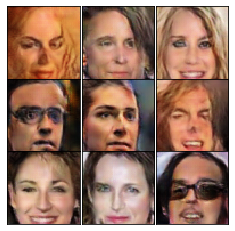

In [13]:
fake_input_test = tf.random_uniform(shape=(9, z_dim),
                                 minval=-1.0, maxval=1.0, dtype=tf.float32)
generated_samples = generator_net(fake_input_test, is_training=False)
display_images(generated_samples.numpy())

# 增加样本集

In [18]:
sample_num=64
sample_files=datas[0:sample_num]
sample=[get_image(sample_file,image_size,is_crop=True) for sample_file in sample_files]
sample_images=np.reshape(np.array(sample).astype(np.float32),[sample_num]+image_shape)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


# 增加图像修复代价函数

In [19]:
def complete_Inpainting_loss(g_loss, mask, G, images,lam):
  
    
    #真图片未破损部分与假图片未破损部分的生成损失
    contextual_loss = tf.reduce_sum(
            tf.contrib.layers.flatten(
                tf.abs(tf.multiply(mask,G) - tf.multiply(mask, images))), 1)
    #感知信息损失（保证全局结构性）
    perceptual_loss=g_loss
    complete_loss = contextual_loss + lam*perceptual_loss
    return complete_loss

# 生成MASK矩阵

In [20]:
def generate_Mask(batch_size):
    scale=0.25 #遮挡部分占全部图片的百分比
    #遮挡图片的MASK矩阵
    mask=np.ones([batch_size]+image_shape).astype(np.float32)
    l=int(image_shape[0]*scale)
    u=int(image_shape[0]*(1.0-scale))
    mask[:,l:u,l:u,:]=0.0


    #取出破损部分的MASK矩阵
    scale=0.25
    imask=np.zeros([batch_size]+image_shape).astype(np.float32)
    l=int(image_shape[0]*scale)
    u=int(image_shape[0]*(1.0-scale))
    imask[:,l:u,l:u,:]=1.0
    
    return mask,imask

# 运行模型

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


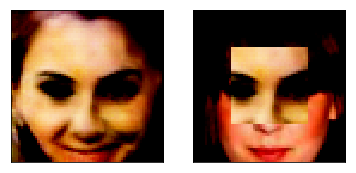

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


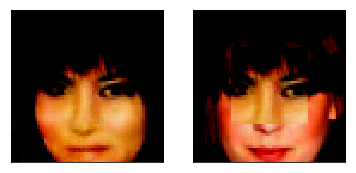

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


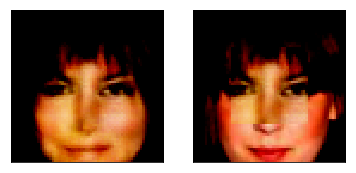

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


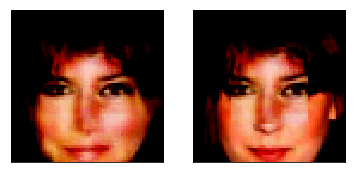

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


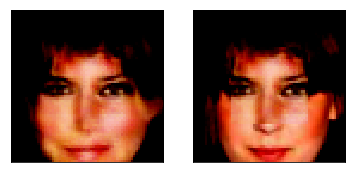

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


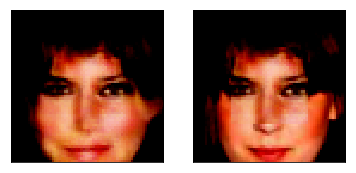

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


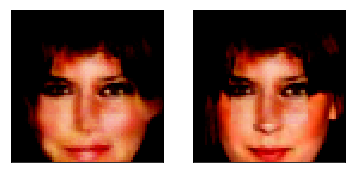

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


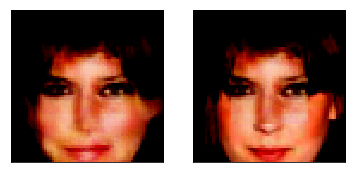

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


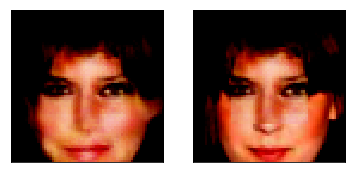

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


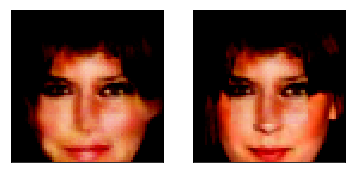

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


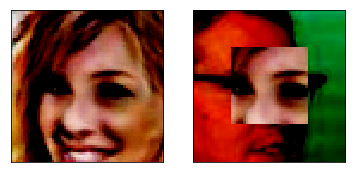

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


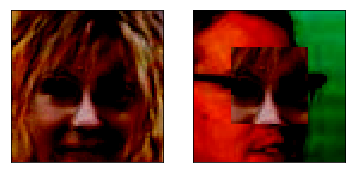

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


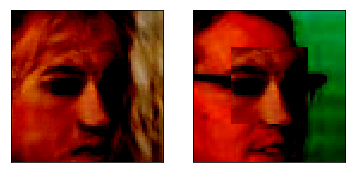

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


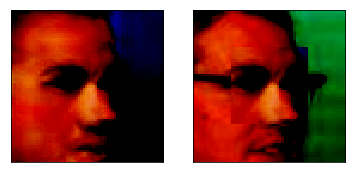

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


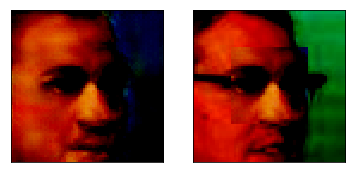

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


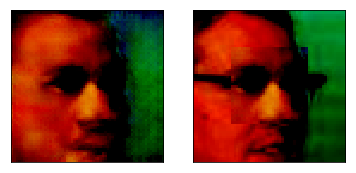

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


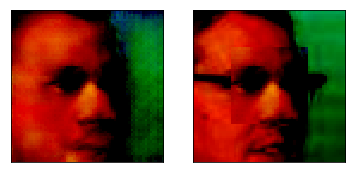

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


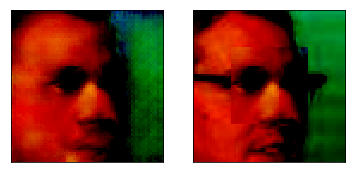

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


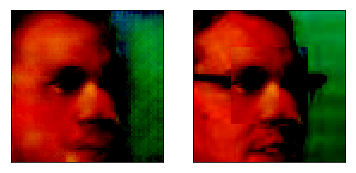

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


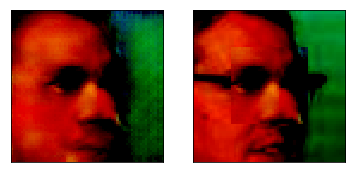

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


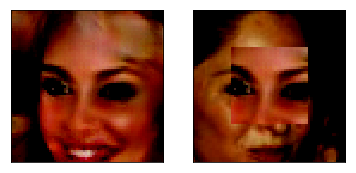

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


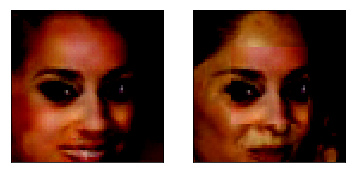

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


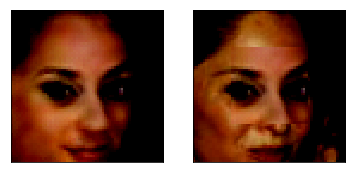

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


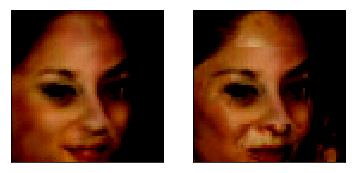

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


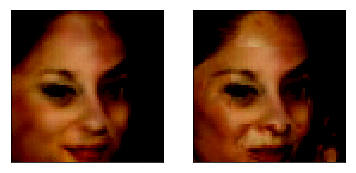

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


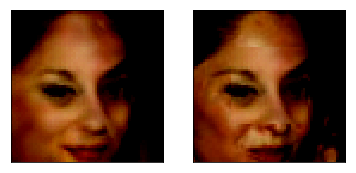

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


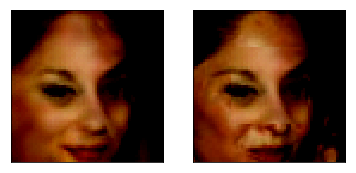

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


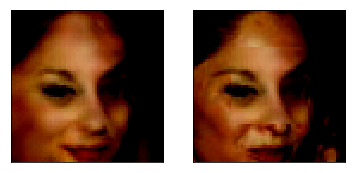

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


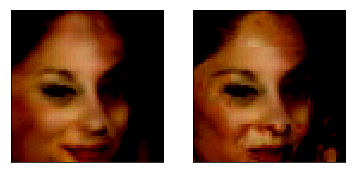

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


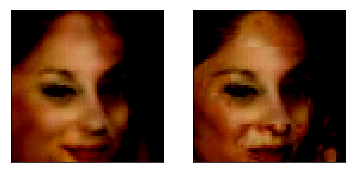

In [ ]:
lam=0.1
nIndex = 500 #图像的迭代次数
beta1=0.9
beta2=0.9
eps=1e-9
lr=0.01
batch_size =64
sample_mask,sample_imask = generate_Mask(sample_num)
mask,imask = generate_Mask(batch_size)
# 生成测试噪声输入
fake_input_test = tf.random_uniform(shape=(sample_num, z_dim),
                                 minval=-1.0, maxval=1.0, dtype=tf.float32)

num_batch = (int)(len(datas)/batch_size)

np.random.shuffle(datas)
for i in range(num_batch):
    #生成以batch为单位的随机噪声
    fake_input = tf.random_uniform(shape=(batch_size, z_dim),
                                     minval=-1.0, maxval=1.0, dtype=tf.float32)
        
    #因为数据过大，采用以batch为单位处理数据集的做法
    batch_files=datas[i*batch_size:(i+1)*batch_size]
    batch=[get_image(batch_file,image_size,is_crop=True) for batch_file in batch_files]
    batch_images=np.reshape(np.array(batch).astype(np.float32),[batch_size]+image_shape)
    
    m = 0
    v = 0
    for ii in range(nIndex):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(fake_input)
            # 运行生成器
            g_model = generator_net(fake_input, is_training=False)

             # 输入假图片运行判别器
            d_model_fake, d_logits_fake = discriminator_net(g_model, is_training=False)

            # 计算生成器的损失
            gen_loss = generator_loss(d_logits_fake, d_model_fake)
            complete_loss = complete_Inpainting_loss(gen_loss, mask, g_model, batch_images,lam)
            g = tape.gradient(target=complete_loss, sources=fake_input)
            
            
        if ii % 50 == 0:
            #生成假图片
            generated_samples = generator_net(fake_input, is_training=False)
            #提取真图片对应假图片的破损部分
            fake_part = np.multiply(generated_samples,sample_imask)
            #破损原图
            real_part = np.multiply(batch_images,sample_mask)
            #通道拼接得到原图
            inpainting_sample = np.add(fake_part,real_part)
            plt.subplot(121)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(generated_samples[0].numpy())
            plt.subplot(122)
            plt.imshow(inpainting_sample[0])
            plt.xticks([])
            plt.yticks([])
            
            plt.show()

        #对单张图片(fake_input)进行更新
        m_prev = np.copy(m)
        v_prev = np.copy(v)
        
        m = beta1 * m_prev + (1 - beta1) * g[0]
        v = beta2 * v_prev + (1 - beta2) * np.multiply(g[0], g[0])
        m_hat = m / (1 - beta1 ** (ii + 1))
        v_hat = v / (1 - beta2 ** (ii + 1))
        fake_input += - np.true_divide(lr * m_hat, (np.sqrt(v_hat) + eps))
        fake_input = tf.convert_to_tensor(np.clip(fake_input, -1, 1))
        
    counter += 1

